
<h1><center> Binomial Markov Switching Multifractal model in python </center></h1>


# Abstract 

Markov Switching Multifractal Model (from here on we call it MSM) is a stochastic volatility model used in finance based on an assumption that the return volatility is a multifractal system. This assumption captures various stylized facts of financial market such as fat tails, scaling, volatility clustering and long memory. Due to this nature, MSM has gained popularity among finance researchers and is widely applied to model volatile assets such as commodity and foreign exchange futures.

Depending on the specification, MSM can either have finite or infinite number of states. Calvet et al \cite{MSM2004} considered the finite case and employed maximum likelihood estimation to estimate parameters of this model by taking into account all possible paths from first order Markov chain and picked the set of parameters with the highest likelihood. This approach is computaionally expensive and will be infeasible quickly when the number of states are increased to enhance its predictive capability. 

In this report, we instead considered applying particle filter to approximate the likelihood and get an estimate of optimal set of parameters. Specifically, we employed Liu and West filter\cite{LWfilter} and examined its performance in relation to the MLE approach with simulated MSM process.

# Background

For this project, we implement and optimize Binomial MSM introduced in Calve et al (2004). MSM is based on a model called Multifractal Model of Asset Returns (MMAR) introduced by Mandelbrot et al (1997) which tries to connect the area of fractal geometry to finance. However, due to its nonstationarity and complex combinatorial nature, MMAR did not gain wide recognition. MSM improves upon this by reconstructing MMAR into a state space model (or hidden Markov model for statisticians) which already has a significant foothold in financial research.

Its multifractal construction allows to model long term dependece of returns in various degrees of frequencies. This is a phenomenon known as scaling in finance which states that volatility in different frequencies (from seconds to all the way up to years) have some connections with each other. Moreover, it will naturally model sudden discontinous jump in volatility which is often hard to model in many mainstream stochastc volatility models even though we can find many examples of such occurances. For exmaple, a generic GARCH model cannot handle such situation and therefore GARH-Jump model was invented with the cost of introducing another parameter.

For this project, we will use Binomial MSM to model highly volatily assests and compare its performance to GARCH which is more widely used model for estimating stochastic volatility.

# Description of the Model


MSM is often denoted as $MSM(\bar k)$ where $\bar k$ is a model parameter (so we don't estimate it) which represents the number of multipliers $M_{i,t}\ \ i = 1,...,\bar k$. We define $M_t$ as a vector of these multipliers at time $t$ which is treated as a state at $t$. In equation it is shown as below.

$$
\begin{align*}
   M_t = (M_{1,t},...,M_{\bar k,t})\in \mathbb{R}^{\bar k}_+.
\end{align*}
$$

Then, each components of $M_t$ have the same marginal distribution $M(\theta)$ but differes in the switching frequency which is given by exogenous parameters $\gamma \equiv (\gamma_1,\gamma_2,...,\gamma_{\bar k})$. Therefore the dynamics of multipliers are specified as following

$$
\begin{align*}
    M_{k,t} = 
    \begin{cases}
        m \sim M(\theta) & \text{with probability $\gamma_k$}\\
        M_{k,t-1} & \text{with probability $1-\gamma_k$}.
    \end{cases}
\end{align*}
$$

The exogenous switching probability $\gamma_k$ is specified as follows

$$
\begin{align*}
    \gamma_k = 1 - (1-\gamma_1)^{b^{k-1}}.
\end{align*}
$$

Due to this construction, multipliers are mutually independent with each other and the stochastic volatility can be considered as a function of the vector $M_t$ with first-order Markov property.

$$
\begin{align*}
    \sigma(M_t) \equiv \bar \sigma * \Big(\prod_{i=1}^{\bar k} M_{k,t}\Big)^{\frac{1}{2}},
\end{align*}
$$

where $\bar \sigma$ is a positive constant to be estimated. Finally, returns $r_t$ are 
specified as

$$
\begin{align*}
    r_t = \sigma(M_t)\epsilon_t \ \ \ \text{where $\epsilon_t \sim N(0,1)$}.
\end{align*}
$$

which is just a realization of the state $\sigma(M_t)$ with the Gaussian error.Thus,the full parameter vector is $\psi \equiv (\theta,\bar \sigma,b,\gamma_{1})$. For the marginal distribution $M(\theta)$, any distribution with positive support will do the job as long as $\mathbb{E}(m) = 1$.


Essentially, MSM$(\bar k)$ is a HMM with $\bar k$ components and if we use the simplest specification of $M(\theta)$ where $m$ only takes two values with equal probability, the transition matrix of the state $M_t$ is $2^{\bar k}*2^{\bar k}$. For this project, we will use this specification and specify $\theta = m_0$ as in the Calver et al (2004) where $M(m_0)$ is a binomial distribution which yields either $m_0$ or $m_1 = 1-m_0$ with equal probability (thus we can specify the parameter of this distribution with $m_0$).

The figure below is a graphical representation of this HMM (grey nodes are non-stochastic).

![](MSM_graph.png)

# Description of the algorithm

Here, we describe author's (Calvet et al) algorithm (written in Matlab) and our direct python implementation of it. 

The Matlab code and our direct implementation will do the estimation of $MSM(\bar k)$ when the user provides the number of multipliers $\bar k$ and the data and returns the estimated value of parameters $\psi \equiv (b,m_0,\gamma_{\bar k},\bar \sigma,)$   (for some reason, they used $\gamma_{\bar k}$ instead of $\gamma_1$). To implement this, the author created two files (and for our implementation two modules). We will briefly describe the function of each of those.

## Starting value search

Our starting_val module is a python translation of author's starting value serch code. Essentially, it finds appropriate starting values of parameters $\psi$ to be used in the MLE.

First, we gave parameters except $m_0$ several candidate values. Then we run scipy.optimize.fminbound and maximized the data likelihood with respect to $m_0$ bounded between 1.2 and 1.8 for all combination of other parameters (so we did grid search).

The return value is the set of parameters $\psi$ with the maximum likelihood.

## Likelihood function

In our likelihood module, we implemented the likelihood function serving in three ways: starting value serch, MLE and state estimation. For this reason, it returns different set of variables depending on the input.

When our input for the set of parameters is not a vector (so the user didn't specify the starting values for the parameters), it will only return the likelihood since in this case the function is used for starting value search.

After running the starting value search, we have access to an appropriate starting value to supply to the function minimizer. Then we use the likelihood function again still limiting the number of output to only the full data likelihood and try global minimum serch with scipy.optimize.basinhopping. Both our algorithm and the original Matlab code will occasionally fail to get the global minimum and can get stuck in the local minimum depending on the complexity of the data as we will see later.

The computation of the exact likelihood goes like this.First we define the conditional probability of $M_t$ being at one of its $2^{\bar k}$ states given the return at time t as 

$$
\begin{align*}
\Pi_t^j = P(M_t = m^j|r_t)
\end{align*}
$$

Then, when we observe the return at time $t+1$, the distribution of the above probability $\Pi_t = (\Pi^1_t,...,\Pi^{2^{\bar k}}_t)$ are updated as follows using the Bayesian update

$$
\begin{align*}
\Pi_{t+1} \propto f(x_{t+1}|M_{t+1} = m^j)\Pi_tA
\end{align*}
$$

where A is the $2^{\bar k}*2^{\bar k}$ transition matrix of states. Then our log likelihood function up to time $T$ can be written as follows

$$
\begin{align*}
\log(L(r_1,...,r_T;\psi) = \sum_{t=1}^T \log(f(x_{t}|M_{t} = m^j)\Pi_{t-1}A)
\end{align*}
$$

Finally, when the input narg is set to something except 1, the likelihood function will not only return the data likelihood but also daily likilihood, the posterior of $\Pi_T$ and daily filtered state estimate (so $\Pi_{t-1}A$ at time $t$).

# Optimization

## Efficient creation of the transition matrix A

First we optimized the function that creates the transition matrix A. Since the dimension of the matrix is $2^{\bar k}*2^{\bar k}$, the computational pressure of this operation will increase exponentially. 

Our first attempt was to simply use jit to make the for loop faster. This did have some effect when $\bar k$ gets large (see the plot below), but was not a significant improvement.

Then we moved on to make the function itself more efficient. Since the original transition matrix creation required two functions to do this (T_mat_template() and transition_mat()) we made it simpler by using np.fromfunc() to create the transition matrix. This lead to a significant improvement in the computation speed even when $\bar k$ is relatively big which is why we chose this function to be used in our final model.

We also tried jit optimization of the new function we created but it did not understand np.fromfunc() part corretly so we had to write a nested for loop to do the same job and it didn't improve much from the second function.

In [1]:
import numpy as np
from numba import jit,vectorize,float64, int64
from Binomial_MSM.MSM.likelihood.original import (transition_mat,
transition_mat_jit,transition_mat_new_jit,T_mat_template)
from Binomial_MSM.MSM.likelihood.new import transition_mat_new

In [2]:
A = [T_mat_template(i) for i in range(2,9)]
params = [3,1.5,0.5,3]

In [3]:
np.allclose(transition_mat(A[5],params,7),transition_mat_jit(A[5],params,7),
            transition_mat_new_jit(params,7),transition_mat_new(params,7))

True

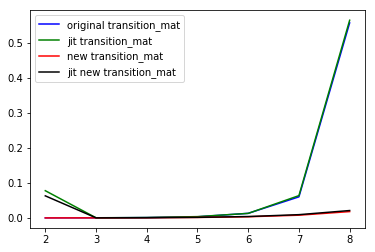

In [4]:
import time
import matplotlib.pyplot as plt
times = np.zeros((4,len(A)))
for i,v in enumerate(A):
    start = time.time()
    transition_mat(v,np.array(params),i+2)
    end = time.time()
    times[0,i] = end-start
    start = time.time()
    transition_mat_jit(v,np.array(params),i+2)
    end = time.time()
    times[1,i] = end-start
    start = time.time()
    transition_mat_new(np.array(params),i+2)
    end = time.time()
    times[2,i] = end-start
    start = time.time()
    transition_mat_new_jit(np.array(params),i+2)
    end = time.time()
    times[3,i] = end-start
plt.plot(np.arange(2,9),times[0,:],color = "blue",label = "original transition_mat")
plt.plot(np.arange(2,9),times[1,:],color = "green",label = "jit transition_mat")
plt.plot(np.arange(2,9),times[2,:],color = "red",label = "new transition_mat")
plt.plot(np.arange(2,9),times[3,:],color = "black",label = "jit new transition_mat")
plt.legend(loc='upper left')
plt.show()

## The use of particle filter for filtering and forecasting

When $\bar k$ is big, obtaining the transition matrix could be prohibitly expensive in terms of computation even after the optimzation of the code. Therefore, we implemented particle filter (or sequencial monte carlo) in filtering and the forecasting process. First we briefly describe the justification of the use of particle filter and then show the procedure for the implementation.

### Justification of particle filter implementation

The following proof provides the justification of the particle filtering we used in the code for approximating $\Pi_{t+1}$ with two stage $M_{T+1}$ sampling.  
Let F a function that maps $\mathbb{R}$ to $\mathbb{R}_{+}^{\bar{k}}$.  
Let d be the number of possible values that $m^{j}$ can take and $R_{t+1} \equiv \{r_s\}_{s=1}^{t+1}$.  
Let $h(m) \equiv P(M_{t+1}|R_t)$
$$
\begin{aligned}
E[F(M_{t+1})|R_{t+1}] &= \sum_{j=1}^d P(M_{t+1}=m^j|R_{t+1})F(m^j) \\
&= \sum_{i=1}^d h(m^j)\frac{P(M_{t+1}=m^j|R_{t+1})}{h(m^j)}F(m^j) \\
&\because h(m^j) = P(M_{t+1} = M^j|R_t), \\
&\text{by the convergence of the Monte Carlo Integration}, \\
E[F(M_{t+1})|R_{t+1}] &\approx \frac{1}{B}\sum_{b=1}^B \frac{P(M_{t+1}=\hat{M}_{t+1}^{(b)}|R_{t+1})}{h(\hat{M}_{t+1}^{(b)})} F(\hat{M}_{t+1}^{(b)}) \\
&\text{by Bayes Rule, the approximation above turns out to be importance sampling} \\
&\because \frac{P(M_{t+1}=\hat{M}_{t+1}^{(b)}|R_{t+1})}{Bh(\hat{M}_{t+1}^{(b)})} = \frac{f_{r_{t+1}}(r_{t+1}|M_{t+1}=\hat{M}_{t+1}^{(b)})}{Bf_{r_{t+1}}(r_{t+1}|R_t)} \\
&\text{Moreover, the denominator can be approximated as follows} \\
f_{r_{t+1}}(r_{t+1}|R_t) &\approx \frac{1}{B}\sum_{b=1}^B f_{r_{t+1}}(r_{t+1}|\hat{M}_{t+1}^{(b)}) \\
&\therefore E[F(M_{t+1})|R_{t+1}] \approx \sum_{b=1}^B \frac{f_{r_{t+1}}(r_{t+1}|M_{t+1}=\hat{M}_{t+1}^{(b)})}
{\sum_{b=1}^B f_{r_{t+1}}(r_{t+1}|\hat{M}_{t+1}^{(b)})} F(\hat{M}_{t+1}^{(b)}) \\
&= \sum_{b=1}^B W_b F(\hat{M}_{t+1}^{(b)})
\end{aligned}
$$
As shown above, The expectation $E[F(M_{t+1})|R_{t+1}]$ can be approximated with the weighted average of the statistics of drawn samples, weighted by the likelihoods of the returns. This resembles the form of approximation using importance sampling. Since, $F$ function was defined as a mapping from the real number space to the positive real value space, $F$ can be replaced with the state conditional probability $\Pi_{t+1}$. Therefore, the proof demonstrates that the code implementation of our particle filtering can be justfied to approximate $\Pi_{t+1}$ with re-sampled $\{\hat{M}_{t+1}^{(i)}  \}_{i=1}^B$

### Procedure of particle filtering

At fixed time $t$,  
i) Draw $\{M_{t+1}^{(i)}\}_{i=1}^B$ using $P(M_{t+1}^{i}|M_{t}^{i})$(one row of a ransition Matrix A).  
ii) Reweight the probability of draws using importance sampling and re-draw $\{\hat{M}_{t+1}^{(i)}\}_{i=1}^B$ using those reweighted probabilities.
  

Assume $\{M_{t}^{(i)}\}_{i=1}^B$ have been independently drawn from $\Pi_t$

$\Pi_{t+1}$ can be updated given a new return $r_{t+1}$ as follows.  
$\Pi_{t+1}^j \propto f_{r_{t+1}}(r_{t+1}|M_{t+1}=m^j)\sum_{i=1}^d P(M_{t+1}=m^j|M_t=m^i)\Pi_t^i$  

In the first step, draw $M_{t+1}^{(i)}$ given $M_{t}^{(i)}$ using one-step ahead Marcov chain property of $M_t$ Repeat this B times, then first stage of $\{M_{t+1}^{(i)}\}_{i=1}^B$ are obtained. Then by taking the weighted average of states, we have a filtered estimate of $M_{t+1}$ using the information up to time $t$. 

Then, once we have the observation at time $t+1$, we can update $M_{t+1}$ incorporating the information of the return at $t+1$ in the following step.

For a fixed sample $b$, calculate $P(q=b) = \frac{f_{r_{t+1}}(r_{t+1}|M_{t+1}=M_{t+1}^{(b)})}{\sum_{a=1}^B f_{r_{t+1}}(r_{t+1}|M_{t+1} = M_{t+1}^{(a)})}$.  
Then draw B samples of $M_{t+1}$ from $\{M_{t}^{(i)}\}_{i=1}^B$ with corresponding weighted probabilities and let them be defined as $\{\hat{M}_{t+1}^{(i)}\}_{i=1}^{B}$. Then it will follow conditional distribution $\Pi_{t+1}$.

### Forecasting using the particle filter

Assume $\{M_{T}^{(i)}\}_{i=1}^B$ is sampled correctly using the method above.

At fixed time $T$,  
i) Draw $\{M_{T+1}^{(b)}\}_{b=1}^B$ using $P(M_{T+1}^{(b)}|M_{T}= M_{T}^{(b)})$.   
ii) Calculate the probability of draws using importance sampling and obtain $\tilde{M}_{T+1}$ using those probabilities.  

In the first step, draw $M_{T+1}^{(b)}$ using one-step forward Marcov chain property of $M_t$. After repeating this sampling for $\forall b$, we are able to obtain temporary samples of $\{\hat{M}_{T+1}^{(i)}\}_{i=1}^B$. 
In the second stage of sampling, we calculate the weight $P(q=b) = \frac{f_{r_{T}}(r_{T}|M_{t+1}=M_{T+1}^{(b)})}{\sum_{a=1}^B f_{r_{T}}(r_{T}|M_{T+1} = M_{T+1}^{(a)})}$ for $\forall b$. Unlike particle filtering for sampling $M_t$ up to t=T where the likelihoods of one period forward returns are used to calculate the weights of each sample,  we are using the likelihood of the return at current time $t=T$ because we do not have $r_{T+1}$ at $t=T$. Finally, the weighted average $\tilde{M}_{T+1} = \sum_{b=1}^B p(q=b)\hat{M}_{T+1}^{(b)}$ can be obtained with samples' corresponding probabilities.  
Since the likelihood of the return at $t=T+1$ is determined by $M_{T+1}$, predicting the stochastic volatility index $M_{T+1}$ is equivalent to implementing a prediction on the return $r_{T+1}$

### Advantages of particle filtering

First, as we can see from the step one of the procedure part, we only need to have a single row of the transition matrix which corresponds to the probability of moving to $2^{\bar k}$ states given current state of the sample. Therefore, the computational complexity of the procedure is linear to $2^{\bar k}$ while the exact computation requires full transition matrix which has a computational complexity squared of $2^{\bar k}$.

Moreover, since a lot of samples are correlated when $\bar k$ is large, we will only sample from the subset of rows.Coupled with the use of Memoization which we implemented by defining the memoization class and added a decorator to the function, this process will only compute those subset of rows once and from the next time when a sample is taken from that state, will just use the transition probabilities stored in the memory. 

Additionally, the step one for both procedure is order invariant. Therefore, we can paralellize this computationally expensive part. For this reason, we implemented multiprocessing with multiprocessing Pool() function.

Finally for any n-step ahead forecasting, particle filter will reuse the samples at the previous time and give it a new state depending on the transition probability and continue this procedure up until it reaches the n-th step. The original approach on the other hand must compute 1st,2nd,...nth power of the transition matrix and apply to the current posterior distribution $\Pi_t$ which is much more expensive operation.


## Description of our implementation of particle filtering

For computational efficiency, the transition_prob() function has a memoize decorator which will store the output of a previously received inputs in the memory to avoid recalculation. This lead to a significant improvement in the computation time of particle filters.

In [5]:
from Binomial_MSM.MSM.likelihood.new import likelihood_new,likelihood_pf

ks = np.arange(4)+8
data = np.random.normal(size = 100).reshape(-1,1)
LLs = np.zeros((2,len(ks)))
times = np.zeros((2,len(ks)))
pis = []
particles = []
weights = []
for i,v in enumerate(ks):
    start = time.time()
    L_,Ls_,pi_T,forward= likelihood_new(params,v,data,None,2)
    end = time.time()
    LLs[0,i] = L_
    pis.append(pi_T)
    times[0,i] = end-start
    start = time.time()
    L,Ls,M,w,p = likelihood_pf(params,v,data,1000)
    end = time.time()
    LLs[1,i] = -L
    particles.append(M)
    weights.append(w)
    times[1,i] = end-start

0
0
0
0


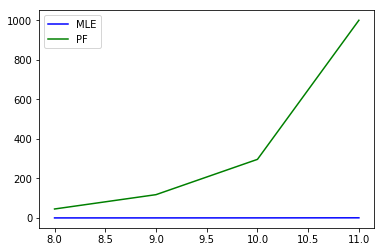

In [6]:
plt.plot(ks,times[0,:],color = "blue",label = "MLE")
plt.plot(ks,times[1,:],color = "green",label = "PF")
plt.legend(loc='upper left')
plt.show()

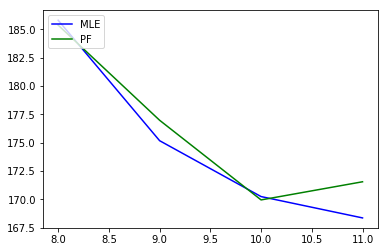

In [7]:
plt.plot(ks,LLs[0,:],color = "blue",label = "MLE")
plt.plot(ks,LLs[1,:],color = "green",label = "PF")
plt.legend(loc='upper left')
plt.show()

In [8]:
from Binomial_MSM.MSM.prediction.predict import prediction,prediction_pf

ks = np.arange(4)+8
data = np.random.normal(size = 1000).reshape(-1,1)
mus = np.zeros((4,len(ks)))
times = np.zeros((2,len(ks)))
for i,v in enumerate(ks):
    start = time.time()
    mu,var= prediction(params,v,pis[i],30)
    mus[0,i] = mu[0]
    mus[1,i] = mu[-1]
    end = time.time()
    times[0,i] = end-start
    start = time.time()
    mu_,var_,par,wei = prediction_pf(params,v,1000,30,particles[i],weights[i])
    end = time.time()
    mus[2,i] = mu_[0]
    mus[3,i] = mu_[-1]
    times[1,i] = end-start

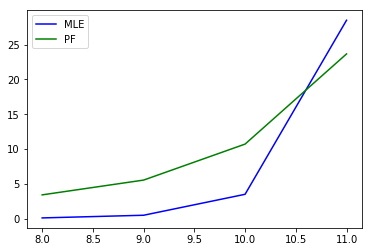

In [9]:
plt.plot(ks,times[0,:],color = "blue",label = "MLE")
plt.plot(ks,times[1,:],color = "green",label = "PF")
plt.legend(loc='upper left')
plt.show()

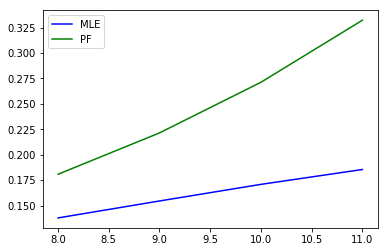

In [10]:
plt.plot(ks,mus[0,:],color = "blue",label = "MLE")
plt.plot(ks,mus[2,:],color = "green",label = "PF")
plt.legend(loc='upper left')
plt.show()

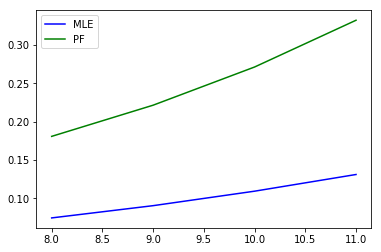

In [11]:
plt.plot(ks,mus[1,:],color = "blue",label = "MLE")
plt.plot(ks,mus[3,:],color = "green",label = "PF")
plt.legend(loc='upper left')
plt.show()

As we can observe, the greater the number of multipliers, particle filter algorithm can produce predictions much faster because the complexity is linear in the dimension.

Although we can also observe that the increase in dimension leads to a decrease in the approximation of likelihood and the predictions, we can partly solve this by taking more samples. Although that may increase the computational burden, sampling part is order invariant and thus it is parallelizable and indeed we have implemented multiprocessing in this part. Therefore, a good cpu with sufficiently many cores will be able to handle the increase in the sample size.

Unfortunately, the filtering part (the part where we have data) even with memoization and multiprocessing takes much longer for the particle filter than the original approach with the full transition matrix. However, there are still room for improvement in the particle filter such as using more efficient resampling algorithm. In this project, we used sampling importance resampling which requiers resampling in every step, but there are other methods that will do resampling only when the effective sample size is below a certain threshold.

# Applications to simulated data

Here we simulate the MSM model and check that our algorithm will capture the true parameters in relatively acceptable accuracy.

The true parameters in our simulated data are $b = 6,m_0 = 1.6,\gamma_{\bar k} = 0.6, \bar \sigma  = 6$ and it's generated from 5 multipliers (so $\bar k = 5$) with 1000 observations.

In [12]:
T = 1000
kbar = 5
g_kbar = 0.6
b = 6
m0 = 1.6
m1 = 2-m0
sig = 6/np.sqrt(252) # we divide sigma by sqrt of the # of trading days
g_s = np.zeros(kbar)
M_s = np.zeros((kbar,T))
g_s[0] = 1-(1-g_kbar)**(1/(b**(kbar-1)))
for i in range(1,kbar):
    g_s[i] = 1-(1-g_s[0])**(b**(i))

for j in range(kbar):
    M_s[j,:] = np.random.binomial(1,g_s[j],T)
dat = np.zeros(T)
tmp = (M_s[:,0]==1)*m1+(M_s[:,0]==0)*m0
dat[0] = np.prod(tmp)
for k in range(1,T):
    for j in range(kbar):
        if M_s[j,k]==1:
            tmp[j] = np.random.choice([m0,m1],1,p = [0.5,0.5])

    dat[k] = np.prod(tmp)
dat = np.sqrt(dat)*sig* np.random.normal(size = T)
dat = dat.reshape(-1,1)

In [13]:
from Binomial_MSM.MSM.MSM import MSM_new

/home/jan/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [14]:
LL,params = MSM_new(dat,5,None,5)

No starting values entered: Using grid-search
[3.0, 1.559292621177156, 0.5, 7.9986362850317878]
387.782585707 [ 9.30156559  1.71665705  0.38089054  5.        ]


In [15]:
print("b = ",params[0],"m_0 = ",params[1],"\n"
      "g_kbar = ",params[2],"sigma = ",params[3])

b =  9.30156558546 m_0 =  1.71665704755 
g_kbar =  0.380890536762 sigma =  5.0


In [16]:
L= likelihood_new(params,5,dat,None,1)
L_pf,Ls,M,w,p = likelihood_pf(params,5,dat,100)

0


In [17]:
print("Exact likelihood = ",L,"\n",
     "Simulated likelihood = ",-L_pf)

Exact likelihood =  387.782585707 
 Simulated likelihood =  421.107566448


As we can see, our algorithm managed to capture the true parameters in a relatively acceptable accuracy.

We can also observe that the exact likelihood and the simulated likelihood obtained from particle filter is also relatively close (and by sampling more it will get much closer).

# Applications to real data

## USD/JPY exchange rate

The daily exchange rate between USD and JPY from June 1st, 1973 to June 28th 2002 is one of the data used in Calvet et al (2004). In the original paper they estimated the parameters using the data up to 1990 and conducted one step predictive analysis through the remainder of the data. First we tried to replecate the estimation result. Following the specification in the paper we used $MSM(10)$ with 10 multipliers.

In [ ]:
import pandas as pd
import re
# preprocessing of data
dat = pd.read_csv("DEXJPUS.csv")
for i,v in enumerate(dat.DATE):
    if re.sub("-.*","",v) == "1990":
        break
    
dat = dat.loc[dat.DEXJPUS != "."].DEXJPUS.astype(float)
dat = np.array(dat)
dat = np.log(dat[1:])-np.log(dat[0:-1])
dat = dat[:,np.newaxis]

In [ ]:
LL,params = MSM_new(dat[:i],10,None,1)

No starting values entered: Using grid-search
[6.0, 1.623323285077462, 0.9, 0.09641264084265197]


In [ ]:
print("b = ",params[0],"m_0 = ",params[1],"\n"
      "g_kbar = ",params[2],"sigma = ",params[3]*100/np.sqrt(252))

The result on the original paper is $b = 3.76 (0.45),m_0 = 1.448 (0.011),\gamma_{\bar k} = 0.998 (0.006), \bar \sigma = 0.461 (0.036)$ where values inside the bracket are standard error and $\bar \sigma$ is daily volatility so the value returned from the algorithm is divded by $\sqrt{252}$ and multiplied by 100 (to change it to percentage) to match with the result in the paper.

The one step analysis they implemented in the paper is too time consuming to do because after obtaining one step ahed prediction, we must recalculate the parameter extimate using the next data and repeat the same process untill the end.

So we insted used the data up to the last 30 observations, and did 30 step forward prediction. This result will be compared with another popular stochastic volatility model, GARCH in the next chapter.

## Oil futures data

Since MSM is commonly used to model highly volatile assets, commodity futures are typical choice of data for this model. We picked the most influential commodity oil and applied MSM for estimation and forecasting.

In [ ]:
dat = pd.read_csv("O")

# Conclusion

In this project, we optimized the estimation of MSM by improving the code and then introduced particle filter for likelihood approximation, state estimation by filtring and n-step ahead forecasting. Then we optimized the particle filter using methods such as multiprocessing and memoization so that it can be more efficient compared with the exact calculation of posterior quantities and prediction employed in the original paper.

Results from simulated and real data presented above colloborates the claim that particle filter is more efficient in high dimensional setting although the concern about the decrease in accuracy may not have been fully addressed.

Although the MSM is built in the context of finance, its construction is more general which only assumes that the process it's tracking is a multifractal system with normal observation noise. Therefore, it may be used in other areas of science as well. Considering that the Mandelbrot who inverted MMAR which lead to the creation of MSM has applied his work concerning fractals in wide variety of areas from math,physics to computer graphics etc this model may have wider audience as well.


Finally, we must acknowledge the limitation of our algorithm which sometimes will get stuck in local minimum and does not return optimal parameter values. However, this was also the case for the author's Matlab code (although fmincon() function used for optimization in their code seems to work much better than our basinhopping L-BFGS-B minimizer).

Moreover, the introduction of particle filters was not just aimed for an increase in filtering and forecasting performance but was also intended to aid parameter estimation. If we can use particle filter instad of MLE to get a parameter estimate, it will speed up the process even more. This is because particle filtering is done sequentially (which is why it's also called sequential monte carlo) and thus whenever a new observation is obtained at time $t$, the update can be just done with the data and the prior (which is a posterior at time $t-1$) whereas MLE must use all the data up to $t$ to recalculate the parameter estimate (or set a window length). However, the parameter estimation with particle filter is a frontier in the area of statistics and considering the time constraints we were unable to implement that.

Therefore, our future aim is to implement some sort of self organizing state space model (proposed by Kitagawa(1998)) to change evey part of MSM process into the context of filtering so that it can become an online learning algorithm which allows sequential updates.